Mean vector for class 1 (training): [0.93930963 1.99933291]
Mean vector for class 2 (training): [2.99097327 5.01891925]

Covariance matrix for class 1 (training):
[[1.96356387 0.8652446 ]
 [0.8652446  2.80115573]]

Covariance matrix for class 2 (training):
[[ 0.99763833 -0.78333547]
 [-0.78333547  3.11843221]]

QDA Training Error Rate: 0.09125
QDA Test Error Rate: 0.09

Pooled covariance matrix:
[[1.4812048  0.04198493]
 [0.04198493 2.95959567]]

LDA Training Error Rate: 0.10125
LDA Test Error Rate: 0.09


<ipython-input-2-237323ef7cd7>:251: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx1, xx2, grid_predictions, levels=[0.5], colors='blue', linestyles='--', linewidths=2, label='QDA Boundary')
<ipython-input-2-237323ef7cd7>:252: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx1, xx2, grid_predictions_lda, levels=[0.5], colors='red', linestyles='-', linewidths=2, label='LDA Boundary')


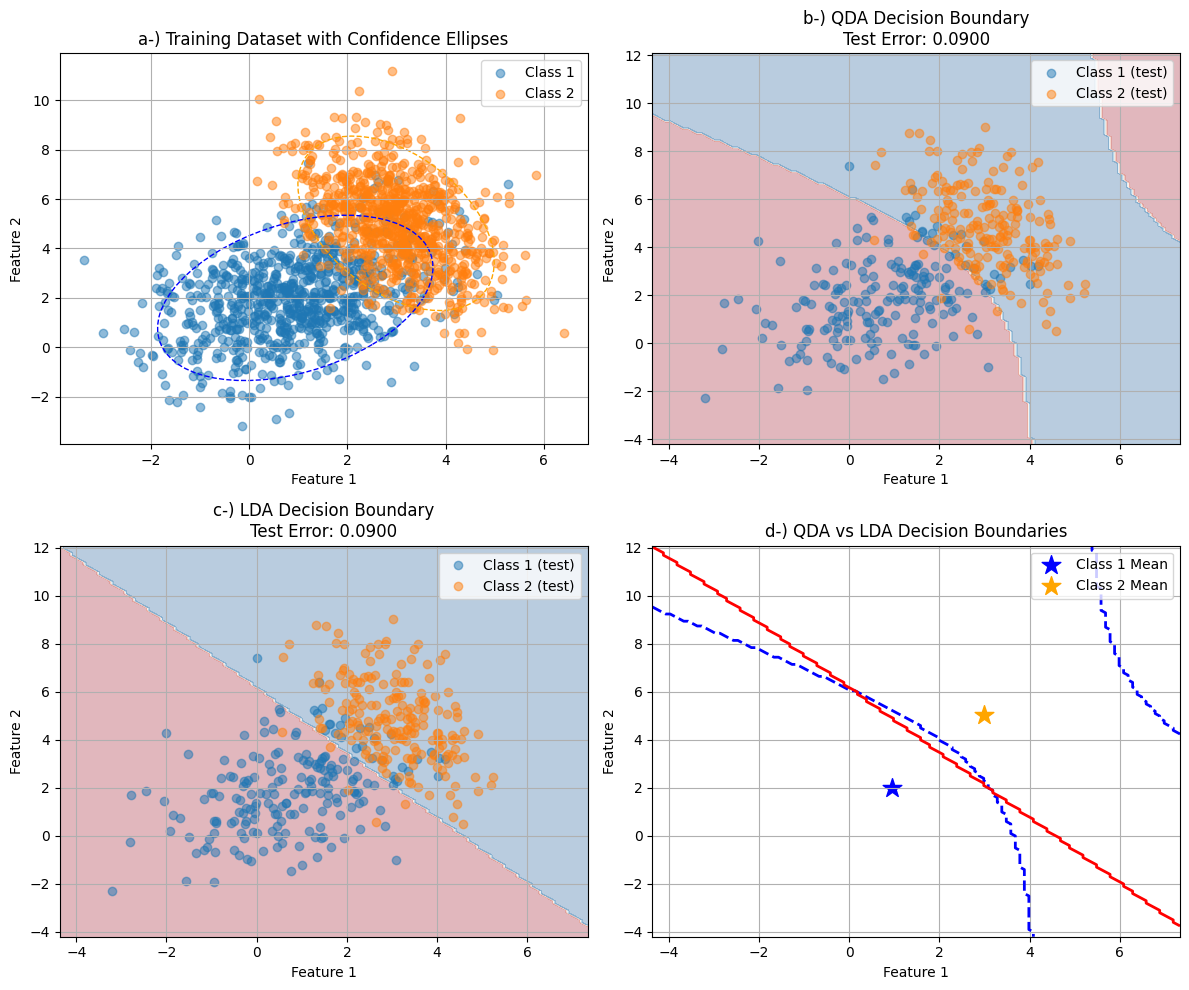


----- Summary of Results -----
Mean vector for class 1: [0.93930963 1.99933291]
Mean vector for class 2: [2.99097327 5.01891925]

Covariance matrix for class 1:
[[1.96356387 0.8652446 ]
 [0.8652446  2.80115573]]

Covariance matrix for class 2:
[[ 0.99763833 -0.78333547]
 [-0.78333547  3.11843221]]

Pooled covariance matrix:
[[1.4812048  0.04198493]
 [0.04198493 2.95959567]]

QDA Training Error Rate: 0.09125
QDA Test Error Rate: 0.09

LDA Training Error Rate: 0.10125
LDA Test Error Rate: 0.09


In [ ]:
#Question 1 Implementation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.model_selection import train_test_split
import math
np.random.seed(42)  # For reproducibility

# Generate data for class 1 and class 2
n_samples = 1000  # per class

# Class 1 parameters
mean1 = np.array([1, 2])
cov1 = np.array([[2, 1], [1, 3]])

# Class 2 parameters
mean2 = np.array([3, 5])
cov2 = np.array([[1, -0.8], [-0.8, 3]])

# Generate multivariate normal samples
class1_data = np.random.multivariate_normal(mean1, cov1, n_samples)
class2_data = np.random.multivariate_normal(mean2, cov2, n_samples)

# Combine data and create labels
X = np.vstack((class1_data, class2_data))
y = np.hstack((np.zeros(n_samples), np.ones(n_samples)))

# 1. Plot the generated datasets
plt.figure(figsize=(10, 8))
plt.scatter(class1_data[:, 0], class1_data[:, 1], alpha=0.5, label='Class 1')
plt.scatter(class2_data[:, 0], class2_data[:, 1], alpha=0.5, label='Class 2')
plt.title('Generated 2D Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# Function to draw confidence ellipses
def plot_confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from the square root of the variance
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transform = np.array([
        [scale_x, 0],
        [0, scale_y]
    ])

    transf = (
        plt.matplotlib.transforms.Affine2D()
        .rotate_deg(45)
        .scale(scale_x, scale_y)
        .translate(mean[0], mean[1])
    )

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Add confidence ellipses
ax = plt.gca()
plot_confidence_ellipse(mean1, cov1, ax, edgecolor='blue', linestyle='--', label='Class 1 covariance')
plot_confidence_ellipse(mean2, cov2, ax, edgecolor='orange', linestyle='--', label='Class 2 covariance')
plt.legend()
plt.savefig('dataset_plot.png')
plt.close()

# 2. Partition dataset into training (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate classes in training set
X_train_c1 = X_train[y_train == 0]
X_train_c2 = X_train[y_train == 1]

# Compute mean vectors manually
def compute_mean(data):
    return np.sum(data, axis=0) / len(data)

mean1_train = compute_mean(X_train_c1)
mean2_train = compute_mean(X_train_c2)

print("Mean vector for class 1 (training):", mean1_train)
print("Mean vector for class 2 (training):", mean2_train)

# Compute covariance matrices manually
def compute_covariance(data, mean):
    n = len(data)
    cov = np.zeros((2, 2))
    for i in range(n):
        diff = data[i] - mean
        cov += np.outer(diff, diff)
    return cov / n

cov1_train = compute_covariance(X_train_c1, mean1_train)
cov2_train = compute_covariance(X_train_c2, mean2_train)

print("\nCovariance matrix for class 1 (training):")
print(cov1_train)
print("\nCovariance matrix for class 2 (training):")
print(cov2_train)

# 3. Design a quadratic discriminant classifier
def quadratic_discriminant(x, mean, cov):
    """Calculate quadratic discriminant function value at point x"""
    diff = x - mean
    # ln(1/sqrt(det(2π*Σ))) simplifies to -0.5*ln(det(Σ)) - ln(2π)
    # We can drop the ln(2π) term as it's constant across classes
    det_term = -0.5 * np.log(np.linalg.det(cov))
    exp_term = -0.5 * diff.T @ np.linalg.inv(cov) @ diff
    return det_term + exp_term

def predict_qda(x):
    """Predict class using quadratic discriminant analysis"""
    score1 = quadratic_discriminant(x, mean1_train, cov1_train)
    score2 = quadratic_discriminant(x, mean2_train, cov2_train)
    return 1 if score2 > score1 else 0

# Calculate QDA error rates
qda_train_preds = np.array([predict_qda(x) for x in X_train])
qda_test_preds = np.array([predict_qda(x) for x in X_test])

qda_train_error = np.mean(qda_train_preds != y_train)
qda_test_error = np.mean(qda_test_preds != y_test)

print("\nQDA Training Error Rate:", qda_train_error)
print("QDA Test Error Rate:", qda_test_error)

# Generate grid for decision boundary
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                       np.arange(x2_min, x2_max, 0.1))
grid_points = np.c_[xx1.ravel(), xx2.ravel()]
grid_predictions = np.array([predict_qda(x) for x in grid_points])
grid_predictions = grid_predictions.reshape(xx1.shape)

# Plot QDA decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx1, xx2, grid_predictions, alpha=0.3, cmap=plt.cm.RdBu)
plt.scatter(X_train_c1[:, 0], X_train_c1[:, 1], alpha=0.5, label='Class 1 (train)')
plt.scatter(X_train_c2[:, 0], X_train_c2[:, 1], alpha=0.5, label='Class 2 (train)')
plt.title('Quadratic Discriminant Analysis\nTraining Error: {:.4f}, Test Error: {:.4f}'.format(
    qda_train_error, qda_test_error))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.savefig('qda_decision_boundary.png')
plt.close()

# 4. Design a linear discriminant classifier using shared covariance
# Compute pooled covariance matrix
n1 = len(X_train_c1)
n2 = len(X_train_c2)
pooled_cov = (n1 * cov1_train + n2 * cov2_train) / (n1 + n2)

print("\nPooled covariance matrix:")
print(pooled_cov)

def linear_discriminant(x, mean1, mean2, pooled_cov):
    """Calculate linear discriminant for point x"""
    # The decision boundary is: (x - (μ₁+μ₂)/2)ᵀ Σ⁻¹(μ₁-μ₂)
    mean_diff = mean1 - mean2
    cov_inv = np.linalg.inv(pooled_cov)
    w = cov_inv @ mean_diff
    c = -0.5 * mean1.T @ cov_inv @ mean1 + 0.5 * mean2.T @ cov_inv @ mean2
    return x @ w + c

def predict_lda(x):
    """Predict class using linear discriminant analysis"""
    score = linear_discriminant(x, mean1_train, mean2_train, pooled_cov)
    return 0 if score > 0 else 1

# Calculate LDA error rates
lda_train_preds = np.array([predict_lda(x) for x in X_train])
lda_test_preds = np.array([predict_lda(x) for x in X_test])

lda_train_error = np.mean(lda_train_preds != y_train)
lda_test_error = np.mean(lda_test_preds != y_test)

print("\nLDA Training Error Rate:", lda_train_error)
print("LDA Test Error Rate:", lda_test_error)

# Generate grid for LDA decision boundary
grid_predictions_lda = np.array([predict_lda(x) for x in grid_points])
grid_predictions_lda = grid_predictions_lda.reshape(xx1.shape)

# Plot LDA decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx1, xx2, grid_predictions_lda, alpha=0.3, cmap=plt.cm.RdBu)
plt.scatter(X_train_c1[:, 0], X_train_c1[:, 1], alpha=0.5, label='Class 1 (train)')
plt.scatter(X_train_c2[:, 0], X_train_c2[:, 1], alpha=0.5, label='Class 2 (train)')
plt.title('Linear Discriminant Analysis\nTraining Error: {:.4f}, Test Error: {:.4f}'.format(
    lda_train_error, lda_test_error))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.savefig('lda_decision_boundary.png')
plt.close()

# Combined plot for comparison
plt.figure(figsize=(12, 10))

# Plot 1: Dataset with confidence ellipses
plt.subplot(2, 2, 1)
plt.scatter(X_train_c1[:, 0], X_train_c1[:, 1], alpha=0.5, label='Class 1')
plt.scatter(X_train_c2[:, 0], X_train_c2[:, 1], alpha=0.5, label='Class 2')
ax = plt.gca()
plot_confidence_ellipse(mean1_train, cov1_train, ax, edgecolor='blue', linestyle='--')
plot_confidence_ellipse(mean2_train, cov2_train, ax, edgecolor='orange', linestyle='--')
plt.title('a-) Training Dataset with Confidence Ellipses')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# Plot 2: QDA Decision Boundary
plt.subplot(2, 2, 2)
plt.contourf(xx1, xx2, grid_predictions, alpha=0.3, cmap=plt.cm.RdBu)
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5, label='Class 1 (test)')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], alpha=0.5, label='Class 2 (test)')
plt.title('b-) QDA Decision Boundary\nTest Error: {:.4f}'.format(qda_test_error))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# Plot 3: LDA Decision Boundary
plt.subplot(2, 2, 3)
plt.contourf(xx1, xx2, grid_predictions_lda, alpha=0.3, cmap=plt.cm.RdBu)
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5, label='Class 1 (test)')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], alpha=0.5, label='Class 2 (test)')
plt.title('c-) LDA Decision Boundary\nTest Error: {:.4f}'.format(lda_test_error))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# Plot 4: Both decision boundaries together
plt.subplot(2, 2, 4)
plt.contour(xx1, xx2, grid_predictions, levels=[0.5], colors='blue', linestyles='--', linewidths=2, label='QDA Boundary')
plt.contour(xx1, xx2, grid_predictions_lda, levels=[0.5], colors='red', linestyles='-', linewidths=2, label='LDA Boundary')
plt.scatter(mean1_train[0], mean1_train[1], color='blue', marker='*', s=200, label='Class 1 Mean')
plt.scatter(mean2_train[0], mean2_train[1], color='orange', marker='*', s=200, label='Class 2 Mean')
plt.title('d-) QDA vs LDA Decision Boundaries')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:4], labels[:4])
plt.grid(True)

plt.tight_layout()
plt.savefig('comparison_plot.png')
plt.show()

# Print summary of results
print("\n----- Summary of Results -----")
print("Mean vector for class 1:", mean1_train)
print("Mean vector for class 2:", mean2_train)
print("\nCovariance matrix for class 1:")
print(cov1_train)
print("\nCovariance matrix for class 2:")
print(cov2_train)
print("\nPooled covariance matrix:")
print(pooled_cov)
print("\nQDA Training Error Rate:", qda_train_error)
print("QDA Test Error Rate:", qda_test_error)
print("\nLDA Training Error Rate:", lda_train_error)
print("LDA Test Error Rate:", lda_test_error)